In [44]:
import os
import json
import pandas as pd
import numpy as np       
import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

# Read in data

In [2]:
MOJO_DIR = os.path.join('..','project_1','data', 'boxofficemojo')
META_DIR = os.path.join('..','project_1','data', 'metacritic')


In [3]:
def load_movie_data():
    movie_list_mojo=[]
    movie_list_meta=[]

    for file1 in os.listdir(MOJO_DIR):
        path=os.path.join(MOJO_DIR,file1)
        with open(path, 'r') as target_file:
            movie = json.load(target_file)
            movie_list_mojo.append(movie)

    for file1 in os.listdir(META_DIR):
        if '_parsed' in str(file1):
            path=os.path.join(META_DIR,file1)
            with open(path, 'r') as target_file:
                movie = json.load(target_file)
                movie_list_meta.append(movie)
    #print 6
    return movie_list_mojo,movie_list_meta

mojo,meta=load_movie_data()[0],load_movie_data()[1]



for i in meta:
    i['num_critic_reviews']=str(i['num_critic_reviews'])
    i['num_user_reviews']=str(i['num_user_reviews'])

meta_df=pd.DataFrame(meta)
mojo_df=pd.DataFrame(mojo)

both_df=pd.merge(mojo_df,meta_df, on='title',how='left')

# Calculate rolling mean
## Rolling mean the mean gross amount for all movies directed by the director prior to the release date

In [4]:
derived_dt=pd.DataFrame()
#Get the mean gross amount for all movies directed by the director prior to the release date. This only returns all 
#observations where director is not missing
both_df['release_date_wide']=pd.to_datetime(both_df['release_date_wide'])
movie_by_drt=both_df.groupby('director_x')

for i in movie_by_drt:
    if len(i[1])>1:
        df=i[1].copy()
        df.sort_values('release_date_wide',ascending=False,inplace=True)
        df.reset_index(drop=True,inplace=True)
        #q=df.index.values
        df['rolling_mean']=np.nan
        for z in range(0,(len(df)-1)):
            df.ix[z,'rolling_mean']= df.ix[(z+1):,'domestic_gross'].mean()
    else:
        df=i[1].copy()
        #break
    try:
        derived_dt=pd.concat([derived_dt,df])
    except:
        derived_dt=df


In [5]:
# Concatenate with the obsversations where director is miss
both_df=pd.concat([derived_dt,both_df[both_df.director_x.isnull()==True]],axis=0)

# Create genre dummy

In [6]:
genre_list = []
for genre in both_df['genre']:
    if type(genre)== list:
        for sub_genre in genre:
            genre_list.append(sub_genre)
    else:
        genre_list.append(genre)

genre_list_pd = pd.Series(genre_list)

In [7]:
def gtype(x, genre_type):
    if type(x) ==list:
        if genre_type in x:
            return(1)
        else:
            return(0)
    else:
        return(0)

for genre_type in genre_list_pd:
    both_df[genre_type]=[gtype(entry,genre_type) for entry in both_df['genre']]
    

# Create # of movies directed by a director

In [12]:
num_of_movies=pd.DataFrame(both_df['director_x'].value_counts())
num_of_movies.reset_index(level=0, inplace=True)
num_of_movies.rename(index=str,columns={'index':'director_x','director_x':'num_of_movies'},inplace=True)
both_df=pd.merge(both_df,num_of_movies,on='director_x',how='left')

# Build linear model

In [13]:
import statsmodels.formula.api as smf


## 1.1 Clean variables

In [14]:
missing_count=both_df.isnull().sum()
dependent_variable=list(missing_count[missing_count<500].index)

In [15]:
column_to_rm=['domestic_gross','mojo_slug','opening_weekend_take','title',np.nan,'Adult','News','','alt_title']
for col in column_to_rm:
    dependent_variable.remove(col)

In [18]:
both_df['year_to_date']=2016-both_df['year_x']
dependent_variable.remove('year_x')
dependent_variable.append('year_to_date')
dependent_variable.append('runtime_minutes')
dependent_variable.append('rolling_mean')
dependent_variable.append('num_of_movies')

In [19]:
buildX=both_df[dependent_variable]
def missing_indicator(x):
    if np.isnan(x):
        return(1)
    else:
        return(0)
buildX['open_per_theater_missing']=map(missing_indicator,buildX['opening_per_theater'])
buildX['widest_release_MI']=map(missing_indicator,buildX['widest_release'])
buildX['runtime_minutes_MI']=map(missing_indicator,buildX['runtime_minutes'])
buildX['rolling_mean_MI']=map(missing_indicator,buildX['rolling_mean'])
buildX['num_of_movies_MI']=map(missing_indicator,buildX['num_of_movies'])

/Users/dow527/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dow527/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dow527/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

In [21]:
buildX.fillna(buildX.median(),inplace=True)

/Users/dow527/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,opening_per_theater,release_date_wide,widest_release,Drama,Mystery,Thriller,Horror,Comedy,Romance,Adventure,...,War,year_to_date,runtime_minutes,rolling_mean,num_of_movies,open_per_theater_missing,widest_release_MI,runtime_minutes_MI,rolling_mean_MI,num_of_movies_MI
0,6485.0,2006-10-13,3214.0,1,1,1,1,0,0,0,...,0,10.0,102.0,43285751.5,1.0,0,0,0,1,0
1,6587.0,2006-02-17,2898.0,0,0,0,0,1,1,0,...,0,10.0,83.0,43285751.5,1.0,0,0,0,1,0
2,1984.0,2011-10-07,10.0,1,0,0,0,0,0,0,...,0,5.0,90.0,43285751.5,1.0,0,0,0,1,0
3,2785.0,2012-03-23,3.0,0,0,0,0,0,0,0,...,0,4.0,104.0,43285751.5,1.0,0,0,1,1,0
4,4430.0,2008-02-14,2220.0,1,0,0,0,1,1,0,...,0,8.0,112.0,43285751.5,1.0,0,0,0,1,0
5,7480.0,2013-12-18,3507.0,0,0,0,0,0,0,0,...,0,3.0,104.0,111323491.0,4.0,0,0,1,0,0
6,10000.0,2008-07-25,3182.0,0,0,0,0,1,0,0,...,0,8.0,98.0,116750840.0,4.0,0,0,0,0,0
7,12369.0,2006-08-04,3807.0,0,0,0,0,0,0,0,...,0,10.0,104.0,85288303.0,4.0,0,0,1,0,0
8,9193.0,2004-07-09,3104.0,0,0,0,0,0,0,0,...,0,12.0,104.0,43285751.5,4.0,0,0,1,1,0
9,1112.0,1999-08-13,1802.0,0,0,0,0,1,0,1,...,0,17.0,95.0,43285751.5,1.0,0,0,0,1,0


In [22]:
buildX['domestic_gross']=both_df['domestic_gross']

/Users/dow527/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [23]:
buildX=buildX.dropna()

## 1.2 Derive month of release

In [24]:
buildX['release_date_wide']=pd.to_datetime(buildX['release_date_wide'])

buildX['release_month']=map(lambda x:x.month,buildX['release_date_wide'])

month=range(1,13)

def r_month(x, month):
    if x == month:
        return(1)
    else:
        return(0)

for release_month in month:
    dummy_v='month'+str(release_month)
    buildX[dummy_v]=[r_month(entry,release_month) for entry in buildX['release_month']]


/Users/dow527/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/dow527/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/dow527/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

## Full model

In [25]:
formula='domestic_gross~opening_per_theater+widest_release+Drama+Mystery+Thriller+Horror+Comedy+Romance\
+Adventure+Music+Musical+Fantasy+Family+Action+Crime+Western+History+Biography+Documentary+Animation+Sport+War\
+year_to_date+open_per_theater_missing+widest_release_MI+runtime_minutes_MI+rolling_mean_MI+rolling_mean+runtime_minutes\
+month1+month2+month3+month4+month5+month6+month7+month8+month9+month10+month11+num_of_movies+num_of_movies_MI'
full_model=smf.ols(formula,data=buildX)
full_model=full_model.fit()

In [26]:
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     116.8
Date:                Fri, 01 Jul 2016   Prob (F-statistic):               0.00
Time:                        09:32:40   Log-Likelihood:                -69070.
No. Observations:                3666   AIC:                         1.382e+05
Df Residuals:                    3623   BIC:                         1.385e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                -7.523e+07   6.32e+06    -11.912      0.000     -8.76e+07 -6.28e+07
opening_per_theater       1358.9063     78.345     17.345      0.000      1205.301  1512.511
widest_release            2.579e+04    647.873     39.807      0.000      2.45e+04  2.71e+04
Drama                     1.941e+06   1.86e+06      1.042      0.298     -1.71e+06  5.59e+06
Mystery                  -2.733e+06   2.81e+06     -0.972      0.331     -8.25e+06  2.78e+06
Thriller                  -1.23e+06   2.18e+06     -0.564      0.573      -5.5e+06  3.04e+06
Horror                   -3.354e+06   3.06e+06     -1.097      0.273     -9.35e+06  2.64e+06
Comedy                    1.846e+06   1.96e+06      0.942      0.346        -2e+06  5.69e+06
Romance                  -2.299e+06   2.05e+06     -1.121      0.262     -6.32e+06  1.72e+06
Adventure                 9.459e+06   2.71e+06      3.493      0.000      4.15e+06  1.48e+07
Music                     -6.53e+06   4.43e+06     -1.473      0.141     -1.52e+07  2.16e+06
Musical                   3.198e+06   6.13e+06      0.522      0.602     -8.82e+06  1.52e+07
Fantasy                  -2.538e+05   2.81e+06     -0.090      0.928     -5.77e+06  5.26e+06
Family                   -4.614e+05    3.5e+06     -0.132      0.895     -7.32e+06   6.4e+06
Action                    9.849e+05   2.41e+06      0.408      0.683     -3.74e+06  5.71e+06
Crime                    -6.464e+05   2.29e+06     -0.283      0.777     -5.13e+06  3.83e+06
Western                  -7.233e+06   7.02e+06     -1.030      0.303      -2.1e+07  6.54e+06
History                  -3.122e+06   4.12e+06     -0.759      0.448     -1.12e+07  4.95e+06
Biography                -2.547e+06   3.42e+06     -0.746      0.456     -9.24e+06  4.15e+06
Documentary               5.921e+06    3.9e+06      1.520      0.129     -1.72e+06  1.36e+07
Animation                 2.573e+07   4.43e+06      5.802      0.000       1.7e+07  3.44e+07
Sport                    -7.638e+06   4.45e+06     -1.716      0.086     -1.64e+07  1.09e+06
War                      -7.684e+06   4.01e+06     -1.917      0.055     -1.55e+07  1.74e+05
year_to_date              9.364e+05   9.34e+04     10.025      0.000      7.53e+05  1.12e+06
open_per_theater_missing  8.349e+06   4.92e+06      1.698      0.090     -1.29e+06   1.8e+07
widest_release_MI        -2.702e+07   6.05e+06     -4.468      0.000     -3.89e+07 -1.52e+07
runtime_minutes_MI       -3.232e+06   2.48e+06     -1.303      0.193      -8.1e+06  1.63e+06
rolling_mean_MI           3.206e+06   1.95e+06      1.644      0.100     -6.17e+05  7.03e+06
rolling_mean                 0.1858      0.022      8.426      0.000         0.143     0.229
runtime_minutes           4.671e+05   4.71e+04      9.911      0.000      3.75e+05  5.59e+05
month1        

## Effect of release month

In [27]:
formula='domestic_gross~month1+month2+month3+month4+month5+month6+month7+month8+month9+month10+month11'
model_month=smf.ols(formula,data=buildX)
model_month=model_month.fit()

In [28]:
model_month.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     20.85
Date:                Fri, 01 Jul 2016   Prob (F-statistic):           1.38e-41
Time:                        09:32:55   Log-Likelihood:                -70528.
No. Observations:                3666   AIC:                         1.411e+05
Df Residuals:                    3654   BIC:                         1.412e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   5.861e+07   3.31e+06     17.703      0.000      5.21e+07  6.51e+07
month1     -2.823e+07   4.63e+06     -6.099      0.000     -3.73e+07 -1.92e+07
month2     -2.888e+07   4.64e+06     -6.222      0.000      -3.8e+07 -1.98e+07
month3     -2.665e+07   4.51e+06     -5.908      0.000     -3.55e+07 -1.78e+07
month4     -3.665e+07   4.51e+06     -8.126      0.000     -4.55e+07 -2.78e+07
month5     -1.212e+07   4.78e+06     -2.536      0.011     -2.15e+07 -2.75e+06
month6      1.005e+06   4.61e+06      0.218      0.827     -8.03e+06     1e+07
month7     -6.259e+06   4.66e+06     -1.344      0.179     -1.54e+07  2.87e+06
month8     -3.019e+07    4.4e+06     -6.858      0.000     -3.88e+07 -2.16e+07
month9      -4.03e+07   4.48e+06     -8.996      0.000     -4.91e+07 -3.15e+07
month10    -3.586e+07   4.39e+06     -8.174      0.000     -4.45e+07 -2.73e+07
month11    -1.754e+07    4.6e+06     -3.811      0.000     -2.66e+07 -8.51e+06
==============================================================================
Omnibus:                     2737.847   Durbin-Watson:                   1.410
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72846.303
Skew:                           3.295   Prob(JB):                         0.00
Kurtosis:                      23.820   Cond. No.                         13.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Month 5 and 6 all positively correlated, can be grouped together as summer_season, and the rest are non-summer-season

In [29]:
def summer_season(x):
    if x['month5']==1 or x['month6']==1==1:
        return 1
    else:
        return 0
def Dec_released(x):
    if x['month12']==1 :
        return 1
    else:
        return 0
buildX['summer_season']=buildX.apply(summer_season,axis=1)
buildX['dec_released']=buildX.apply(Dec_released,axis=1)

/Users/dow527/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dow527/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Refit model only with significant variables

In [35]:
formula3='domestic_gross~widest_release+Adventure+Documentary+Animation+rolling_mean+num_of_movies+np.square(widest_release)\
+runtime_minutes+summer_season+dec_released'
simplified_model=smf.ols(formula3,data=buildX)
simplified_model=simplified_model.fit()

In [36]:
simplified_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     438.8
Date:                Fri, 01 Jul 2016   Prob (F-statistic):               0.00
Time:                        09:33:53   Log-Likelihood:                -69194.
No. Observations:                3666   AIC:                         1.384e+05
Df Residuals:                    3655   BIC:                         1.385e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                 -6.555e+07   4.54e+06    -14.434      0.000     -7.45e+07 -5.67e+07
widest_release            -3003.6803   1870.975     -1.605      0.108     -6671.939   664.578
Adventure                  6.114e+06   2.52e+06      2.423      0.015      1.17e+06  1.11e+07
Documentary                1.925e+06    3.5e+06      0.549      0.583     -4.95e+06   8.8e+06
Animation                  2.189e+07   3.98e+06      5.504      0.000      1.41e+07  2.97e+07
rolling_mean                  0.1400      0.023      6.191      0.000         0.096     0.184
num_of_movies              2.298e+06   2.38e+05      9.659      0.000      1.83e+06  2.76e+06
np.square(widest_release)     9.0932      0.574     15.829      0.000         7.967    10.220
runtime_minutes            4.939e+05   4.27e+04     11.574      0.000       4.1e+05  5.78e+05
summer_season              1.414e+07    1.8e+06      7.857      0.000      1.06e+07  1.77e+07
dec_released               1.607e+07   2.44e+06      6.586      0.000      1.13e+07  2.09e+07
==============================================================================
Omnibus:                     3288.104   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           221375.214
Skew:                           3.994   Prob(JB):                         0.00
Kurtosis:                      40.222   Cond. No.                     4.35e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.35e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Residual plot for simplified model

/Users/dow527/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


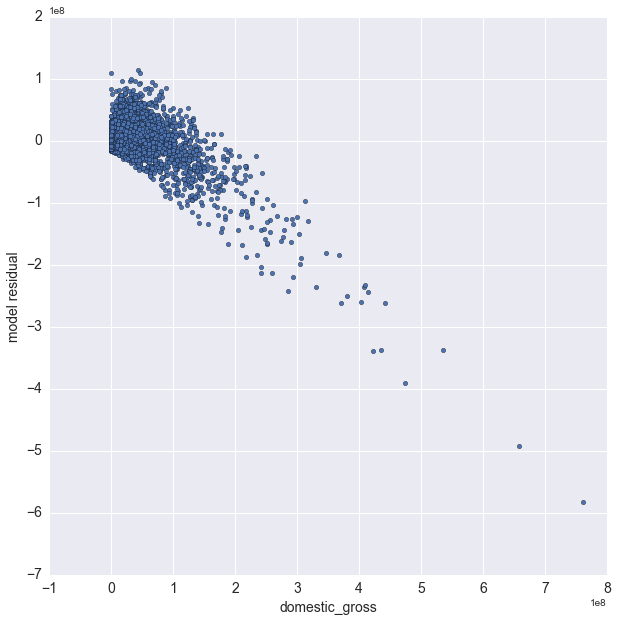

In [70]:
buildX['model_residual']=simplified_model.predict(buildX)-buildX['domestic_gross']
buildX.plot(kind='scatter',x='domestic_gross', y='model_residual',figsize=(10,10),fontsize=14)
plt.xlabel('domestic_gross',fontsize=14)
plt.ylabel('model residual',fontsize=14)

# How good is our prediction?

/Users/dow527/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


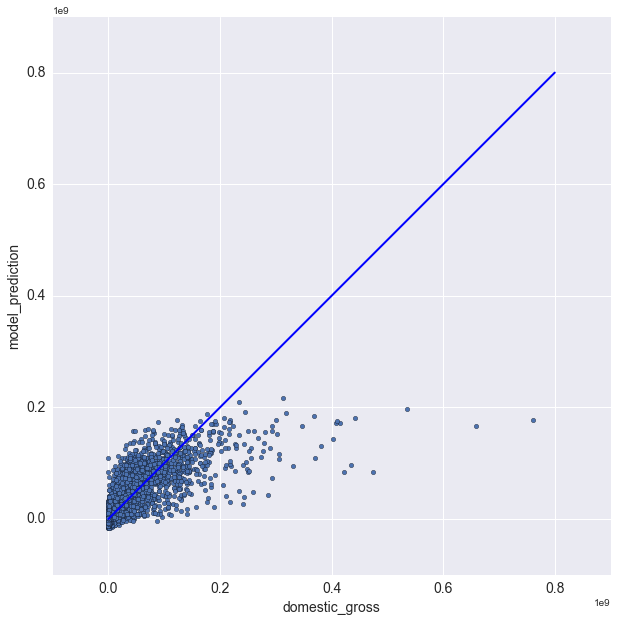

In [68]:

buildX['model_prediction']=simplified_model.predict(buildX)
buildX.plot(kind='scatter',x='domestic_gross', y='model_prediction',figsize=(10,10),fontsize=14)
plt.plot([0, 800000000], [0, 800000000], 'b-', lw=2)
plt.xlabel('domestic_gross',fontsize=14)
plt.ylabel('model_prediction',fontsize=14)

# Visualization of key insights

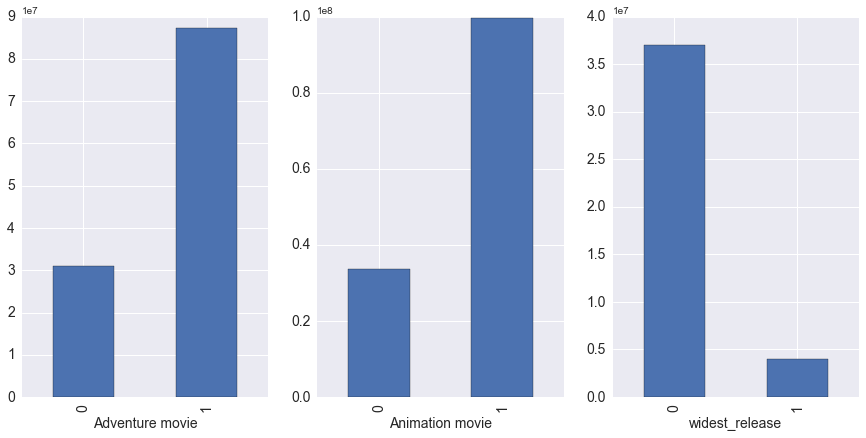

In [66]:
plt.subplot(2,3,1)
both_df.groupby('Adventure')['domestic_gross'].mean().plot(kind='bar',figsize=(15,15),fontsize=14)
plt.xlabel('Adventure movie',fontsize=14)
plt.subplot(2,3,2)
both_df.groupby('Animation')['domestic_gross'].mean().plot(kind='bar',fontsize=14)
plt.xlabel('Animation movie',fontsize=14)
plt.subplot(2,3,3)
both_df.groupby('Documentary')['domestic_gross'].mean().plot(kind='bar',fontsize=14)
plt.xlabel('widest_release',fontsize=14)

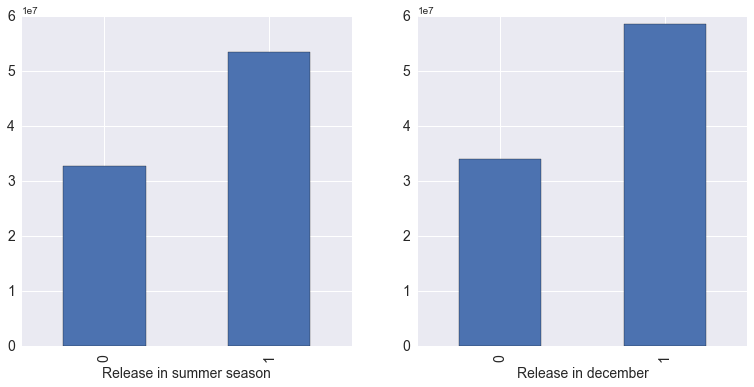

In [64]:
plt.subplot(2,2,1)
buildX.groupby('summer_season')['domestic_gross'].mean().plot(kind='bar',figsize=(13,13),fontsize=14)
plt.xlabel('Release in summer season',fontsize=14)
plt.subplot(2,2,2)
buildX.groupby('dec_released')['domestic_gross'].mean().plot(kind='bar',figsize=(13,13),fontsize=14)
plt.xlabel('Release in december',fontsize=14)

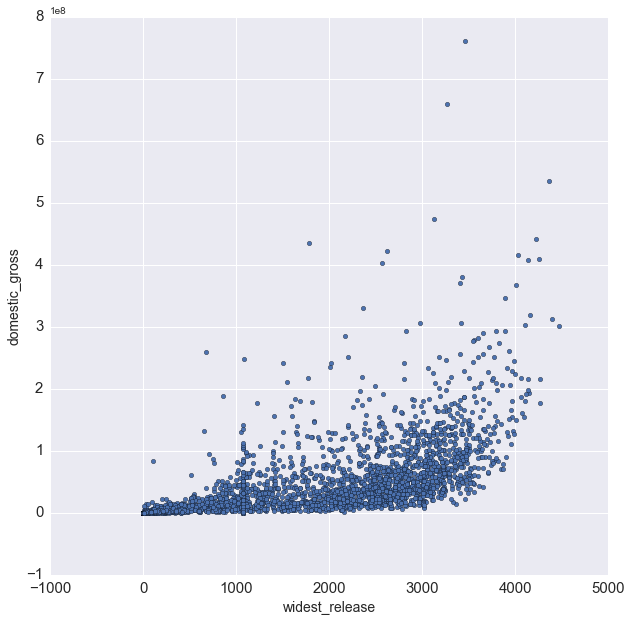

In [65]:
buildX.plot(kind='scatter',x='widest_release', y='domestic_gross',figsize=(10,10),fontsize=15)
plt.xlabel('widest_release',fontsize=14)
plt.ylabel('domestic_gross',fontsize=14)